## Learning Analytics - Multiple Linear Regression

Data Source: https://www.kaggle.com/rocki37/open-university-learning-analytics-dataset
Data description: https://analyse.kmi.open.ac.uk/open_dataset#description

Database Schema:
<img src="files/model.png">

## Initial Question: 
Can we use what we know about students, and their engagement on the VLE to predict assessment outcomes?  

We will use:  
average number of clicks per module  
average score on assessments per module

## Loading the Data

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

assessments = pd.read_csv('assessments.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_info = pd.read_csv('studentInfo.csv')
vle_activity = pd.read_csv('studentVLE.csv')

#we only need code_module so that we can perform a join with studenAssessment and then studentInfo tables
assessments.drop(['code_presentation','assessment_type','date','weight'], axis = 1, inplace = True)
#assessments.code_module.value_counts()

In [390]:
#merge individual assessments data with assessment data, so that we know which module each assessment belongs to
comb_assess = pd.merge(student_assessment,assessments,on='id_assessment')
comb_assess.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
comb_assess.dtypes

id_assessment     int64
id_student        int64
score            object
code_module      object
dtype: object

In [391]:
#clean some of the data - we don't want score as a string, we want it as an integer. So let's remove the ?
comb_assess.drop(comb_assess[comb_assess.score == '?'].index, inplace = True);
comb_assess.score = comb_assess.score.astype(int);
comb_assess.dtypes

id_assessment     int64
id_student        int64
score             int64
code_module      object
dtype: object

In [393]:
#how much data do we have?
comb_assess.shape

(173739, 4)

In [396]:
#group by student and then subgroup by module, so that we retain ability to evaluate different module predictability
grouped = comb_assess.groupby(['id_student','code_module']).mean()
grouped.sort_values('id_student')
#we can't keep id_assessment, because we have just grouped by module. We have to group by module, as our vle interaction data is 
#only grouped by module
grouped.drop(['id_assessment'],axis=1,inplace = True)
grouped.head()

score
id_student code_module           
6516       AAA          61.800000
8462       DDD          87.000000
11391      AAA          82.000000
23629      BBB          82.500000
23698      CCC          74.444444

In [397]:
student_info.shape

(32593, 12)

Text(0, 0.5, 'Number of students')

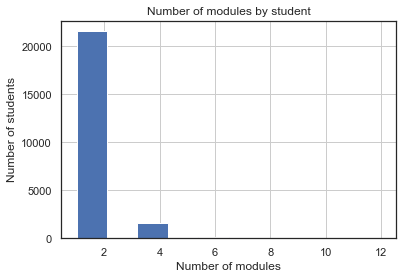

In [401]:
#put it all together
student_all_info = pd.merge(student_info,grouped,on='id_student')
#just getting a feel for it - how many modules is each student enrolled in?
student_all_info.groupby(['id_student']).code_module.count().sort_values().hist()
plt.title('Number of modules by student')
plt.xlabel('Number of modules')
plt.ylabel('Number of students')

Note: The plot above shows most students are enrolled in one module. 

In [403]:
#total number of clicks per student by module
vle_grouped = vle_activity.groupby(['id_student','code_module']).sum()
#we have to drop the columns below as we have grouped by student and subgrouped by module, so they are meaningless
vle_grouped.drop(['id_site','date'],axis=1,inplace=True)
vle_grouped.head()


sum_click
id_student code_module           
6516       AAA               2791
8462       DDD                656
11391      AAA                934
23629      BBB                161
23698      CCC                910

In [252]:
student_all_info.shape

(30335, 13)

In [253]:
#left join as we want to keep student info where no clicks were made
df = pd.merge(student_all_info,vle_grouped,on = ['id_student','code_module'],how='left')

In [254]:
df.shape

(30335, 14)

In [405]:
#remove rows where there are null values for sum_click. There are only 201 so it won't have a huge impact
df.dropna(inplace=True)

In [406]:
#save the new table
df.to_csv('joinedData.csv',index=False)

So we now have a dataframe with student info, average assessment score for that module and average number of clicks for that module. We will now inspect the data for missing data, and ensure it's clean. 

## We need to create the categorical variables

In [407]:
df.dtypes

code_module             category
code_presentation       category
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts     float64
studied_credits         category
disability              category
final_result            category
sum_click                float64
dtype: object

In [409]:
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.highest_education = pd.Categorical(df.highest_education)
df.imd_band = pd.Categorical(df.imd_band)
df.age_band = pd.Categorical(df.age_band)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

In [260]:
df.dtypes

code_module             category
code_presentation       category
id_student                 int64
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts       int64
studied_credits            int64
disability              category
final_result            category
score                    float64
sum_click                float64
dtype: object

## Initial exploration of the data

In [261]:
df.head()

code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       31604      F     South East Region   
3         AAA             2013J       32885      F  West Midlands Region   
4         AAA             2013J       38053      M                 Wales   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   50-60%    35-55                     0   
3     Lower Than A Level   50-60%     0-35                     0   
4  A Level or Equivalent   80-90%    35-55                     0   

   studied_credits disability final_result  score  sum_click  
0              240          N         Pass   82.0      934.0  
1               60          N         Pass   66.4     1435.0  
2               60          N         Pass   76.0     2158.0  
3               60          N         Pass   54.4     1034.0  
4               60          N         Pass   68.0     2445.0

In [262]:
import plotly.express as px
data = df
fig = px.box(data, x="code_module", y="score",title='Student average scores by Module')

fig.show()

In [263]:
data = df
fig = px.box(data, x="region", y="score",title='Student average scores by Region')

fig.show()

All modules have a lower tail, and 6 out of 7 have zero scores included  
Let's look at numbers of each highest_education

Index(['A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
       'No Formal quals', 'Post Graduate Qualification'],
      dtype='object')

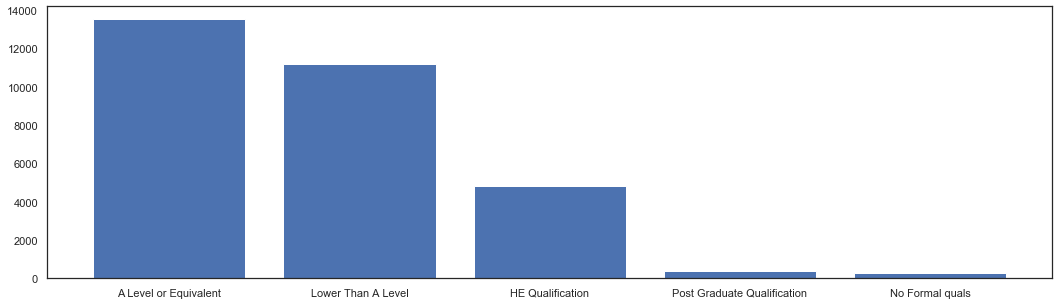

In [264]:
highest_ed = df.highest_education.value_counts()
f, ax = plt.subplots(figsize=(18,5))
plt.bar(highest_ed.index,highest_ed)
df.highest_education.cat.categories

### We need to be careful about generalising for the two categories Post Grad and No prior quals as they only have small numbers

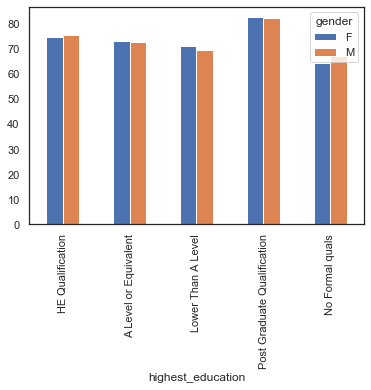

In [265]:
#for_bar = df.groupby(['gender','highest_education']).score.mean()
for_bar = df.pivot_table(index = 'highest_education', columns='gender', values = 'score')
#fig = px.scatter(for_bar,x='score',y='highest_education', color="gender",
                # title="Gender Earnings Disparity",
                # labels={"salary":"Annual Salary (in thousands)"} # customize axis label
                #)
for_bar.plot(kind='bar')

## No real differences between male and female in terms of prior qualification

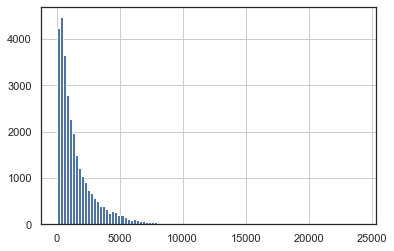

In [266]:
df.sum_click.hist(bins=100)
plt.set_xlabel = 'Total number of clicks for that module'

In [267]:
df.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'score', 'sum_click'],
      dtype='object')

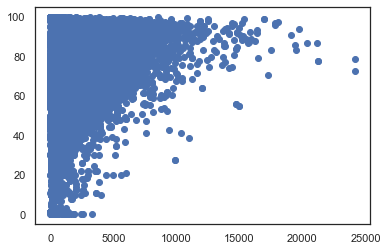

In [268]:
plt.scatter((df.sum_click),(df.score))

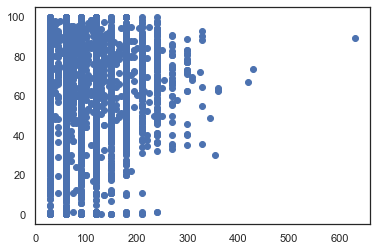

In [269]:
plt.scatter((df.studied_credits),(df.score))

We should bin the studied_credits data, as it would make more sense as categorical

In [270]:
bins = [0,50,100,150,200,250,300,350,400,450,500,550,600]
df['studied_credits'] = pd.cut(df['studied_credits'], bins=bins)

In [271]:
#piv = df.pivot_table(index = df.gender, columns = df.code_module,values='score')
df2 = df.groupby(['gender','code_module']).score.mean()

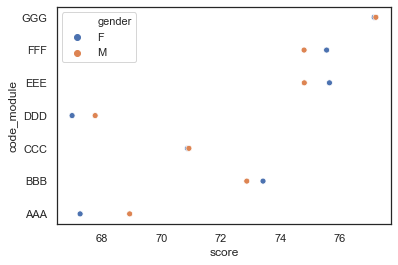

In [272]:
import seaborn as sns
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df2,df2.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');

## Women tend to be more engaged with the vle

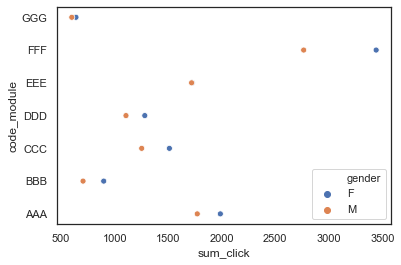

In [273]:
df3 = df.groupby(['gender','code_module']).sum_click.mean()
codes =  df2.index.get_level_values(1)
codes
sns.scatterplot(df3,df3.index.get_level_values(1), hue = df2.index.get_level_values(0), legend='full');

## Does this translate to higher scores? Not clearly

Let's check we have enough in each module to draw conclusions - yes we do

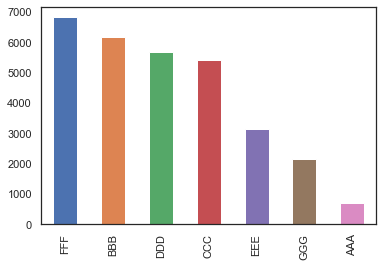

In [274]:
df.code_module.value_counts().plot(kind='bar')

## Does the total number of clicks impact the final result?

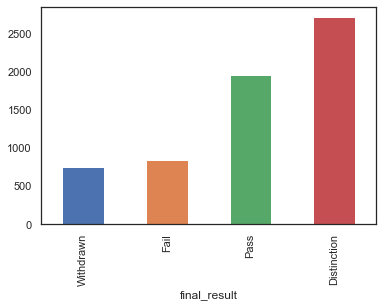

In [275]:
df.groupby('final_result').sum_click.mean().sort_values().plot(kind='bar',)

So there does seem to be some pattern between final score and engagement on the vle

Let's look at the range now

In [276]:
data = df
fig = px.box(data, x="final_result", y="sum_click",title='Student final score by the total clicks on the vle')

fig.show()

So it looks like there are some keen beans skewing our conclusion a bit, but there is still some difference in clicks by result  

And how about final score and average score for that module? There should be a relationship no?

## It looks as though the number of clicks above 700 isn't that predictive, but below 700 could be

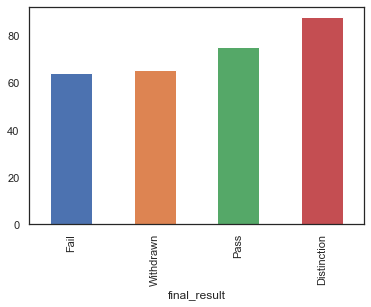

In [277]:
df.groupby('final_result').score.mean().sort_values().plot(kind='bar',)

## Let's look just at those people/modules that have less than 700 clicks, and see if it's more predictive

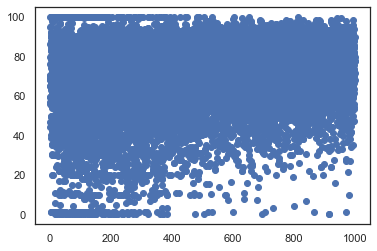

In [278]:
plt.scatter((df.sum_click[df.sum_click < 1000]),(df.score[df.sum_click < 1000]))

makes sense!

In [279]:
#df.id_site = df.id_site.astype(str, inplace=True)
df.dtypes

code_module             category
code_presentation       category
id_student                 int64
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts       int64
studied_credits         category
disability              category
final_result            category
score                    float64
sum_click                float64
dtype: object

In [280]:
df.isnull().sum()
df.dropna(inplace=True)

Columns that should be categories: ['gender', 'code_module','code_presentation','region','highest_education','age_band', 'disability','final_result']

In [281]:
df.describe()

id_student  num_of_prev_attempts         score     sum_click
count  3.013300e+04          30133.000000  30133.000000  30133.000000
mean   7.058065e+05              0.150931     72.475811   1558.836492
std    5.462933e+05              0.456801     16.855059   1791.296185
min    6.516000e+03              0.000000      0.000000      1.000000
25%    5.101860e+05              0.000000     64.000000    416.000000
50%    5.902150e+05              0.000000     76.000000    957.000000
75%    6.373470e+05              0.000000     84.666667   2046.000000
max    2.698588e+06              6.000000    100.000000  24139.000000

So num_of_prev_attempts is heavily positively skewed. studied_credits might have significant outliers. There is a large variation in sum_click, with std larger than mean. 

In [282]:
df_target = df.score
df.drop(['score'],axis=1,inplace=True)
df.drop(['id_student'],axis=1,inplace=True)

Check for multicollinearity

In [283]:
df.head()
df.dtypes

code_module             category
code_presentation       category
gender                  category
region                  category
highest_education       category
imd_band                category
age_band                category
num_of_prev_attempts       int64
studied_credits         category
disability              category
final_result            category
sum_click                float64
dtype: object

In [284]:
#Check multicollinearity
from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()
corr

num_of_prev_attempts  sum_click
num_of_prev_attempts              1.000000  -0.033929
sum_click                        -0.033929   1.000000

There is no significant multicollinearity between independent variables  

Next, let's normalise the continuous variables - num_of_prev_attempts, studied_credits,score,date, sum_clicks, plus the target variable score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e4cf6d8>,
      dtype=object)

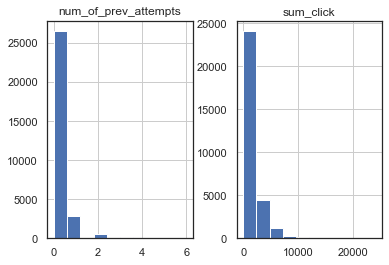

In [285]:
df.hist()

In [286]:
df.num_of_prev_attempts = (df.num_of_prev_attempts - df.num_of_prev_attempts.mean())/df.num_of_prev_attempts.std()
df.sum_click = (df.sum_click - df.sum_click.mean())/df.sum_click.std()
df_target = (df_target - df_target.mean())/df_target.std()


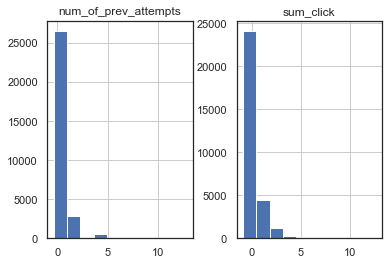

In [287]:
df.hist();

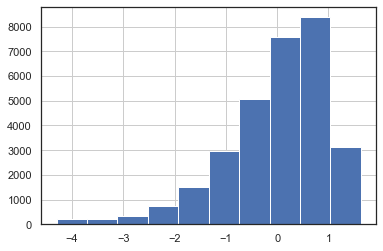

In [288]:
df_target.hist()

### How normal are these independent variables?

In [289]:
#test skew and kurtosis
print("Kurtosis",df.kurtosis(axis=0))
print("Skew",df.skew(axis=0))
print("Target Kurtosis",df_target.kurtosis(axis=0))
print("Target Skew",df_target.skew(axis=0))


Kurtosis num_of_prev_attempts    20.168328
sum_click               14.620519
dtype: float64
Skew num_of_prev_attempts    3.880055
sum_click               2.924741
dtype: float64
Target Kurtosis 2.2216777806993075
Target Skew -1.262121844298866


All variables have positive skewness and kurtosis nowhere near zero, so we need to perform a log transformation. 

### Perform log transformation on the variables - apart from date which has negative values

In [329]:
df_trans = df
df_trans.head()
df_trans['num_of_prev_attempts'] = np.log(df.num_of_prev_attempts)
df_trans['studied_credits'] = np.log(df.studied_credits)
df_trans['sum_click'] = np.log(df.sum_click)
df_trans_target = np.log(df_target)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in log



TypeError: Series with dtype category cannot perform the numpy op log

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e5b62b0>,
      dtype=object)

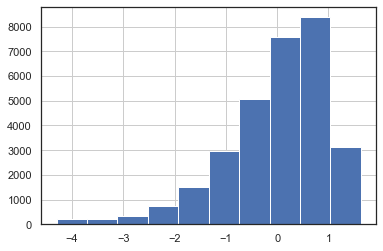

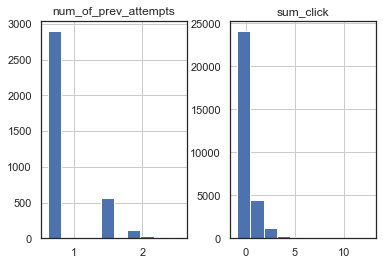

In [330]:
df_target.hist()
df_trans.hist()

# Modelling

## One hot encoding

In [331]:
df_trans = pd.get_dummies(df_trans)
df_trans.shape
df_trans.dtypes
for i in df_trans.columns[2:]:
    df_trans[i] = df_trans[i].astype('category')

In [332]:
df_trans.dtypes
df_trans['score']=df_target


## Check for Linearity between each independent variable and the target variable

(30133, 66)

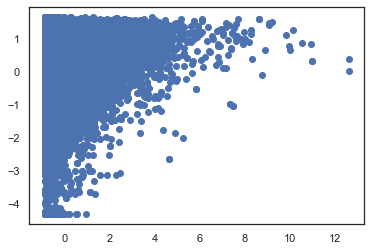

In [333]:
plt.scatter(df_trans['sum_click'],df_target)
df_trans.sum_click.isnull().sum()
df_trans.shape

In [334]:
#replace spaces in strings with _ for modelling purposes
df_trans.columns = df_trans.columns.str.replace(' ', '_')
df_trans.columns = df_trans.columns.str.replace('-', '_')
df_trans.columns = df_trans.columns.str.replace('%', '')
df_trans.columns = df_trans.columns.str.replace('?', '')
df_trans.columns = df_trans.columns.str.replace('<', '')
df_trans.columns = df_trans.columns.str.replace('=', '')
df_trans.columns = df_trans.columns.str.replace(']', ')')
df_trans.columns = df_trans.columns.str.replace('(', '')
df_trans.columns = df_trans.columns.str.replace(')', '')
df_trans.columns = df_trans.columns.str.replace(',', '')

df_trans.head()

num_of_prev_attempts  sum_click code_module_AAA code_module_BBB  \
0                   NaN  -0.348818               1               0   
1                   NaN  -0.069132               1               0   
2                   NaN   0.334486               1               0   
3                   NaN  -0.292993               1               0   
4                   NaN   0.494705               1               0   

  code_module_CCC code_module_DDD code_module_EEE code_module_FFF  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

  code_module_GGG code_presentation_2013B    ...    studied_credits_450_500  \
0               0                       0    ...                          0   
1               0                       0    ...                          0   
2               0                       0    ...                          0   
3               0                       0    ...                          0   
4               0                       0    ...                          0   

  studied_credits_500_550 studied_credits_550_600 disability_N disability_Y  \
0                       0                       0            1            0   
1                       0                       0            1            0   
2                       0                       0            1            0   
3                       0                       0            1            0   
4                       0                       0            1            0   

  final_result_Distinction final_result_Fail final_result_Pass  \
0                        0                 0                 1   
1                        0                 0                 1   
2                        0                 0                 1   
3                        0                 0                 1   
4                        0                 0                 1   

  final_result_Withdrawn     score  
0                      0  0.565064  
1                      0 -0.360474  
2                      0  0.209088  
3                      0 -1.072426  
4                      0 -0.265547  

[5 rows x 66 columns]

## Let's look at linear regression by variable

In [335]:
import statsmodels.formula.api as smf

dfcol = ['num_of_prev_attempts','sum_click']
result = []
for count, i in enumerate(dfcol):
    formula = 'score ~' + ' ' + i
    model = smf.ols(formula, data = df_trans).fit()
    #print(model.params[0],model.params[1],model.pvalues[1])
    result.append([i, model.rsquared, model.params[0],model.params[1],model.pvalues[1]])
result

[['num_of_prev_attempts',
  0.002246358649616642,
  -0.10725847121656625,
  -0.12752907034031682,
  0.004351844107439202],
 ['sum_click',
  0.07018164270858851,
  1.5716594692349872e-14,
  0.2649181811589926,
  0.0]]

So not great. Let's try the categorical variables

In [336]:
df_trans.columns

Index(['num_of_prev_attempts', 'sum_click', 'code_module_AAA',
       'code_module_BBB', 'code_module_CCC', 'code_module_DDD',
       'code_module_EEE', 'code_module_FFF', 'code_module_GGG',
       'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East_Anglian_Region', 'region_East_Midlands_Region',
       'region_Ireland', 'region_London_Region', 'region_North_Region',
       'region_North_Western_Region', 'region_Scotland',
       'region_South_East_Region', 'region_South_Region',
       'region_South_West_Region', 'region_Wales',
       'region_West_Midlands_Region', 'region_Yorkshire_Region',
       'highest_education_A_Level_or_Equivalent',
       'highest_education_HE_Qualification',
       'highest_education_Lower_Than_A_Level',
       'highest_education_No_Formal_quals',
       'highest_education_Post_Graduate_Qualification', 'imd_band_0_10',
       'imd_band_10_20', 'imd_ban

In [337]:
cols_module= df_trans.columns[2:9]
cols_pres= df_trans.columns[9:13]
cols_gender = df_trans.columns[13:15]
cols_region = df_trans.columns[13:28]
cols_ed = df_trans.columns[28:33]
cols_imd = df_trans.columns[33:44]
cols_age = df_trans.columns[44:47]
cols_cred = df_trans.columns[47:59]
cols_dis = df_trans.columns[59:61]
cols_result = df_trans.columns[61:65]

print(cols_result)


Index(['final_result_Distinction', 'final_result_Fail', 'final_result_Pass',
       'final_result_Withdrawn'],
      dtype='object')


In [338]:
cols = [cols_module, cols_pres , cols_gender, cols_region,cols_ed,cols_imd,cols_age,cols_cred,cols_dis,cols_result]
for col in cols:
    sum_cols = "+".join(col)
    form = "score ~" + sum_cols
    model = smf.ols(formula= form, data= df_trans).fit()
    #model = smf.ols(formula, data = df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     145.8
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          1.86e-212
Time:                        14:58:43   Log-Likelihood:                -42254.
No. Observations:               30133   AIC:                         8.452e+04
Df Residuals:                   30125   BIC:                         8.459e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -5.75e+09 

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     100.7
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          1.18e-105
Time:                        14:58:44   Log-Likelihood:                -42507.
No. Observations:               30133   AIC:                         8.503e+04
Df Residuals:                   30127   BIC:                         8.508e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     2525.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:58:44   Log-Likelihood:                -39377.
No. Observations:               30133   AIC:                         7.876e+04
Df Residuals:                   30129   BIC:                         7.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Let's drop some of the less predictive columns, and one from each category

In [339]:
df_final = df_trans.drop(["num_of_prev_attempts","code_module_AAA","code_presentation_2013B","gender_F","region_East_Anglian_Region","highest_education_No_Formal_quals","imd_band_0_10","studied_credits_550_600","disability_Y","final_result_Fail"], axis=1)
y = df_final[["score"]]
X = df_final.drop(["score"], axis=1)

In [340]:
df_final.shape

(30133, 56)

In [341]:
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression



r_list = []
adj_r_list = []
list_n = list(range(1,56,2))
for n in list_n: 
    linreg = LinearRegression()
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(X, np.ravel(y))
    selected_columns = X.columns[select_n.support_ ]
    linreg.fit(X[selected_columns],y)
    yhat = linreg.predict(X[selected_columns])
    SS_Residual = np.sum((y-yhat)**2)
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print(r_squared)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print(adjusted_r_squared)
r_list.append(r_squared)
adj_r_list.append(adjusted_r_squared)

score    0.112767
dtype: float64
score    0.111144
dtype: float64
score    0.200315
dtype: float64
score    0.198852
dtype: float64
score    0.201818
dtype: float64
score    0.200358
dtype: float64
score    0.203809
dtype: float64
score    0.202353
dtype: float64
score    0.206469
dtype: float64
score    0.205018
dtype: float64
score    0.219351
dtype: float64
score    0.217924
dtype: float64
score    0.2269
dtype: float64
score    0.225486
dtype: float64
score    0.228644
dtype: float64
score    0.227234
dtype: float64
score    0.230968
dtype: float64
score    0.229562
dtype: float64
score    0.239777
dtype: float64
score    0.238387
dtype: float64
score    0.240643
dtype: float64
score    0.239254
dtype: float64
score    0.241559
dtype: float64
score    0.240172
dtype: float64
score    0.242215
dtype: float64
score    0.240829
dtype: float64
score    0.243066
dtype: float64
score    0.241682
dtype: float64
score    0.243154
dtype: float64
score    0.24177
dtype: float64
score    0.24

We aren't getting much accuracy here. Let's go back and see if we can use any data we dropped initially

# What about if we look at individual pieces of content - do they impact assessment scores?

This is 1700000 data points instead of 30000

In [342]:
assessments = pd.read_csv('assessments.csv')
comb_assess = pd.merge(student_assessment,assessments,on='id_assessment')
comb_assess.drop(comb_assess[comb_assess.score == '?'].index, inplace = True);

student_all_info = pd.merge(comb_assess,student_info,on='id_student',how='left')
vle = pd.read_csv('vle.csv')


In [356]:
vle_activity = pd.merge(vle_activity,vle,on='id_site')
vle_activity.head()

code_module_x code_presentation_x  id_student  id_site  date  sum_click  \
0           AAA               2013J       28400   546652   -10          4   
1           AAA               2013J       28400   546652   -10          1   
2           AAA               2013J       28400   546652   -10          1   
3           AAA               2013J       28400   546652   -10          8   
4           AAA               2013J       30268   546652   -10          3   

  code_module_y code_presentation_y activity_type_x week_from_x week_to_x  \
0           AAA               2013J         forumng           ?         ?   
1           AAA               2013J         forumng           ?         ?   
2           AAA               2013J         forumng           ?         ?   
3           AAA               2013J         forumng           ?         ?   
4           AAA               2013J         forumng           ?         ?   

  code_module code_presentation activity_type_y week_from_y week_to_y  
0         AAA             2013J         forumng           ?         ?  
1         AAA             2013J         forumng           ?         ?  
2         AAA             2013J         forumng           ?         ?  
3         AAA             2013J         forumng           ?         ?  
4         AAA             2013J         forumng           ?         ?

In [375]:
tot = vle_activity.groupby('id_site').sum_click.sum()
vle_activity.dtypes
tot.head()

id_site
526721    586632
526735     27693
526737    152414
526738    366998
526739     21315
Name: sum_click, dtype: int64

In [384]:
len(tot[tot<2])
len(tot)

6268

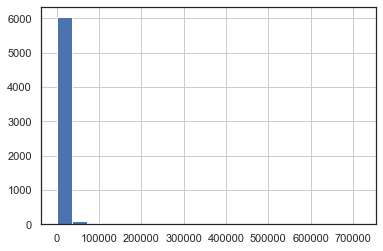

In [385]:
tot.hist(bins=20)

It seems that most people click once, if at all. So it's difficult to get much nuance in this data. 